In [1]:
import os
import sys
# sys.path.append("/Users/shashanks./Downloads/Installations/ddn/")
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
from bernstein import bernstein_coeff_order10_new
from ddn.pytorch.node import AbstractDeclarativeNode

# from utils.nodes.OPTNode_waypoint import OPTNode
from utils.nodes.OPTNode import OPTNode
from utils.dataloader import ArgoverseDataset

from utils.models.ddn import *

from utils.bernstein import bernstein_coeff_order10_new
from utils.viz_helpers import plot_traj, plot_trajj
from utils.metrics import get_ade, get_fde

import pytorch_lightning as pl
device = 'cpu'

num = 30
t_obs = 20
num_elems = 15
include_centerline = False
name = "final_without" if include_centerline else "final_with"
lr = 0.0005
shuffle = True
num_waypoints = 2

train_dir = "/datasets/argoverse/val_data.npy"
centerline_train_dir="/datasets/argoverse/val_centerlines.npy"
test_dir = "/datasets/argoverse/val_test_data.npy"
centerline_test_dir="/datasets/argoverse/val_test_centerlines.npy"
val_offsets_dir = "/datasets/argoverse/val_offsets.npy"

(1000, 50, 2)
AB


In [2]:
train_dataset = ArgoverseDataset(train_dir, centerline_dir=centerline_train_dir, t_obs=t_obs, dt=0.3, include_centerline = include_centerline)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=shuffle, num_workers=0)

test_dataset = ArgoverseDataset(test_dir, centerline_dir=centerline_test_dir, t_obs=t_obs, dt=0.3, include_centerline = include_centerline)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=shuffle, num_workers=0)

offsets_train = np.load(val_offsets_dir)
# offsets_test = np.load("/datasets/argoverse/val_offsets_test.npy")

problem = OPTNode(rho_eq=10, t_fin=9.0, num=num, bernstein_coeff_order10_new=bernstein_coeff_order10_new, device = device)
opt_layer = DeclarativeLayer(problem)

# model = TrajNetLSTM(opt_layer, problem.P, problem.Pdot)#, input_size=t_obs * 2 + include_centerline * num_elems * 2)
# model = TrajNet(opt_layer, problem.P, problem.Pdot)#, input_size=t_obs * 2 + include_centerline * num_elems * 2)
model = TrajNet(opt_layer, problem.P, problem.Pdot, input_size=t_obs * 2 + include_centerline * num_elems * 2)
# model = TrajNet(opt_layer, problem.P, problem.Pdot, input_size=t_obs * 2 + include_centerline * num_elems * 2, output_size = num_waypoints * 2 + 2)
model = model.double()
model = model.to(device)

# model.load_state_dict(torch.load("./checkpoints/final.ckpt"))

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

torch.Size([20, 40]) torch.Size([20, 60])


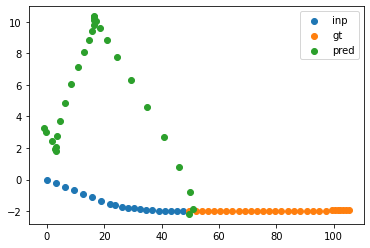

In [3]:
for batch_num, data in enumerate(train_loader):
    traj_inp, traj_out, fixed_params, var_inp = data
    torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
    print(traj_inp.size(), traj_out.size())
    ade = []
    fde = []
#     out = model(traj_inp.float(), fixed_params.float(), var_inp.float())
    out = model(traj_inp, fixed_params, var_inp)
#     print(out.shape)
    plt.scatter(traj_inp[1][:40:2], traj_inp[1][1:40:2], label='inp')
#     plt.scatter(traj_inp[1,:, 0], traj_inp[1, :, 1], label='inp')
#     plt.scatter(traj_out[1,:, 0], traj_out[1, :, 1], label='gt')
#     plt.scatter(out[1,:, 0].detach(), out[1, :, 1].detach(), label='pred')

    plt.scatter(traj_out[1][:30], traj_out[1][30:], label='gt')
    plt.scatter(out[1][:30].detach(), out[1][30:].detach(), label='pred')
    if include_centerline:
        inp_len=t_obs * 2
        c_len = t_obs * 2 + num_elems * 2
        plt.plot(traj_inp[1][inp_len:c_len:2] , traj_inp[1][inp_len + 1:c_len:2], color='black',label='primary-centerline')
    plt.legend()
    break

In [5]:
epoch_train_loss = []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = []
    mean_ade = []
    mean_fde = []    
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)

        ade = []
        fde = []            
#         out = model(traj_inp.float(), fixed_params.float(), var_inp.float())
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j].item(),out[ii][j + num].item()] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j].item(),traj_out[ii][j + num].item()] for j in range(len(out[ii])//2)]
#             ade.append(get_ade(np.array(out[ii].detach()), np.array(traj_out[ii].detach())))
#             fde.append(get_fde(np.array(out[ii].detach()), np.array(traj_out[ii].detach())))
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                                    
            plot_trajj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=t_obs * 2, c_len = t_obs * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
            print("ADE: {}".format(np.mean(ade)), "FDE: {}".format(np.mean(fde)))

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))

    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    torch.save(model.state_dict(), "./checkpoints/{}.ckpt".format(name))
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))
    print("-"*100)

Epoch: 0, Batch: 0, Loss: 5.1573038581523845
ADE: 2.2491151651486705 FDE: 4.140242548004378
Epoch: 0, Batch: 10, Loss: 14.043553709732809
ADE: 4.129184686207301 FDE: 6.297686647999344
Epoch: 0, Batch: 20, Loss: 6.561469529151563
ADE: 2.2192018195426746 FDE: 4.800603751231942
Epoch: 0, Batch: 30, Loss: 7.598198798847422
ADE: 2.506468708627979 FDE: 5.50902909200563
Epoch: 0, Batch: 40, Loss: 7.668572023746768
ADE: 3.0333935545442796 FDE: 4.3594993355438785
Epoch: 0, Mean Loss: 20.28342486141093
Mean ADE: 3.906202697222491 Mean FDE: 7.68203801460102
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 17.979011678379763
ADE: 3.8001243924131183 FDE: 6.71147293786665


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    cnt = 0
    test_loss = []
    mean_ade = []
    mean_fde = []     
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)
        
        ade = []
        fde = []        
        
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        test_loss.append(loss.item())
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                        
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))  

mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))
print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))